In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

22/05/20 12:01:25 WARN Utils: Your hostname, Jesses-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en0)
22/05/20 12:01:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/20 12:01:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/20 12:01:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/20 12:01:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


1. Read the case, department, and source data into their own spark dataframes.

In [2]:
source = spark.read.csv("lessons/source.csv", sep=",", header=True, inferSchema=True)
case = spark.read.csv("lessons/case.csv", header=True, inferSchema=True)
dept = spark.read.csv("lessons/dept.csv", header=True, inferSchema=True)

2. Let's see how writing to the local disk works in spark:

    - Write the code necessary to store the source data in both csv and json format, store these as sources_csv and sources_json
    - Inspect your folder structure. What do you notice?

In [3]:
# source.write.csv('sources_csv')
# source.write.json('sources_json')

Created directory with one json and one csv as well as a SUCCESS file

3. Inspect the data in your dataframes. Are the data types appropriate? Write the code necessary to cast the values to the appropriate types.

In [4]:
source.show(2)

+---------+----------------+
|source_id| source_username|
+---------+----------------+
|   100137|Merlene Blodgett|
|   103582|     Carmen Cura|
+---------+----------------+
only showing top 2 rows



In [5]:
source.printSchema()

root
 |-- source_id: string (nullable = true)
 |-- source_username: string (nullable = true)



Looks appropiate

In [6]:
case.show(2)

+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|   case_id|case_opened_date|case_closed_date|SLA_due_date|case_late|      num_days_late|case_closed|   dept_division|service_request_type|   SLA_days|case_status|source_id|     request_address|council_district|
+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|1014127332|     1/1/18 0:42|    1/1/18 12:29|9/26/20 0:42|       NO| -998.5087616000001|        YES|Field Operations|        Stray Animal|      999.0|     Closed| svcCRMLS|2315  EL PASO ST,...|               5|
|1014127333|     1/1/18 0:46|     1/3/18 8:11| 1/5/18 8:30|       NO|-2.0126041669999997|        YES|     Storm Water|Removal Of Obstru...|4.322222222| 

In [7]:
case.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)



In [8]:
case = case.withColumnRenamed("SLA_due_date", "case_due_date")

In [9]:
# Make case closed and case late columns booleans
case = case.withColumn("case_closed", expr('case_closed == "YES"')).withColumn(
    "case_late", expr('case_late == "YES"')
)

In [10]:
# handle dates
print("--- Before handling dates")
case.select("case_opened_date", "case_closed_date", "case_due_date").show(5)

fmt = "M/d/yy H:mm"
case = (
    case.withColumn("case_opened_date", to_timestamp("case_opened_date", fmt))
    .withColumn("case_closed_date", to_timestamp("case_closed_date", fmt))
    .withColumn("case_due_date", to_timestamp("case_due_date", fmt))
)

print("--- After")
case.select("case_opened_date", "case_closed_date", "case_due_date").show(5)


--- Before handling dates
+----------------+----------------+-------------+
|case_opened_date|case_closed_date|case_due_date|
+----------------+----------------+-------------+
|     1/1/18 0:42|    1/1/18 12:29| 9/26/20 0:42|
|     1/1/18 0:46|     1/3/18 8:11|  1/5/18 8:30|
|     1/1/18 0:48|     1/2/18 7:57|  1/5/18 8:30|
|     1/1/18 1:29|     1/2/18 8:13| 1/17/18 8:30|
|     1/1/18 1:34|    1/1/18 13:29|  1/1/18 4:34|
+----------------+----------------+-------------+
only showing top 5 rows

--- After
+-------------------+-------------------+-------------------+
|   case_opened_date|   case_closed_date|      case_due_date|
+-------------------+-------------------+-------------------+
|2018-01-01 00:42:00|2018-01-01 12:29:00|2020-09-26 00:42:00|
|2018-01-01 00:46:00|2018-01-03 08:11:00|2018-01-05 08:30:00|
|2018-01-01 00:48:00|2018-01-02 07:57:00|2018-01-05 08:30:00|
|2018-01-01 01:29:00|2018-01-02 08:13:00|2018-01-17 08:30:00|
|2018-01-01 01:34:00|2018-01-01 13:29:00|2018-01-01 04:

Add features

In [11]:
case = (
    case.withColumn(
        "case_age", datediff(current_timestamp(), "case_opened_date")
    )
    .withColumn(
        "days_to_closed", datediff("case_closed_date", "case_opened_date")
    )
    .withColumn(
        "case_lifetime",
        when(expr("! case_closed"), col("case_age")).otherwise(
            col("days_to_closed")
        ),
    )
)

case.select(
    "case_closed",
    "case_opened_date",
    "case_closed_date",
    "case_age",
    "days_to_closed",
    "case_lifetime",
).where(expr("case_closed")).show(5)

case.select(
    "case_closed",
    "case_opened_date",
    "case_closed_date",
    "case_age",
    "days_to_closed",
    "case_lifetime",
).where(expr("! case_closed")).show(5)


+-----------+-------------------+-------------------+--------+--------------+-------------+
|case_closed|   case_opened_date|   case_closed_date|case_age|days_to_closed|case_lifetime|
+-----------+-------------------+-------------------+--------+--------------+-------------+
|       true|2018-01-01 00:42:00|2018-01-01 12:29:00|    1600|             0|            0|
|       true|2018-01-01 00:46:00|2018-01-03 08:11:00|    1600|             2|            2|
|       true|2018-01-01 00:48:00|2018-01-02 07:57:00|    1600|             1|            1|
|       true|2018-01-01 01:29:00|2018-01-02 08:13:00|    1600|             1|            1|
|       true|2018-01-01 01:34:00|2018-01-01 13:29:00|    1600|             0|            0|
+-----------+-------------------+-------------------+--------+--------------+-------------+
only showing top 5 rows

+-----------+-------------------+----------------+--------+--------------+-------------+
|case_closed|   case_opened_date|case_closed_date|case_age

In [12]:
case.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)
 |-- case_age: integer (nullable = true)
 |-- days_to_closed: integer (nullable = true)
 |-- case_lifetime: integer (nullable = true)



1. How old is the latest (in terms of days past SLA) currently open issue? How long has the oldest (in terms of days since opened) currently opened issue been open?

In [13]:
case.filter(case.case_closed == False).sort(case.num_days_late.desc()).select('num_days_late').show(1)

+-------------+
|num_days_late|
+-------------+
|  348.6458333|
+-------------+
only showing top 1 row



In [14]:
case.filter(case.case_closed == False).sort(case.case_age.desc()).select('case_age').show(1)

+--------+
|case_age|
+--------+
|    1965|
+--------+
only showing top 1 row



2. How many Stray Animal cases are there?

In [15]:
case.filter('service_request_type = "Stray Animal"').count()

26760

3. How many service requests that are assigned to the Field Operations department (dept_division) are not classified as "Officer Standby" request type (service_request_type)?

In [16]:
# How many service requests that are assigned to the Field Operations department (dept_division) 
# are not classified as "Officer Standby" request type (service_request_type)?
case.filter(case.dept_division == 'Field Operations').filter(case.service_request_type != 'Officer Standby').count()


113902

4. Convert the council_district column to a string column.

In [17]:
# Cast council district to string
case = case.withColumn("council_district", col("council_district").cast("string"))

5. Extract the year from the case_closed_date column.

In [18]:
case.select(year(case.case_closed_date)).show(6, vertical=True)

-RECORD 0----------------------
 year(case_closed_date) | 2018 
-RECORD 1----------------------
 year(case_closed_date) | 2018 
-RECORD 2----------------------
 year(case_closed_date) | 2018 
-RECORD 3----------------------
 year(case_closed_date) | 2018 
-RECORD 4----------------------
 year(case_closed_date) | 2018 
-RECORD 5----------------------
 year(case_closed_date) | 2018 
only showing top 6 rows



6. Convert num_days_late from days to hours in new columns num_hours_late.

In [19]:
case.withColumn('num_hours_late', expr('num_days_late / 24')).select('num_hours_late','num_days_late').show(5)

+--------------------+-------------------+
|      num_hours_late|      num_days_late|
+--------------------+-------------------+
|  -41.60453173333334| -998.5087616000001|
|-0.08385850695833331|-2.0126041669999997|
|-0.12593074845833332|       -3.022337963|
|        -0.625478395|       -15.01148148|
|0.015506848000000002|0.37216435200000003|
+--------------------+-------------------+
only showing top 5 rows



7. Join the case data with the source and department data.

In [20]:
### join dept data
df = (
    case
    # left join on dept_division
    .join(dept, "dept_division", "left")
    # drop all the columns except for standardized name, as it has much fewer unique values
    .drop(dept.dept_division)
    .drop(dept.dept_name)
    .drop(case.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    # convert to a boolean
    .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
)

df.show(2, vertical=True)



-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 case_age             | 1600                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1------------------------------------
 case_id              | 1014127333           
 case_opened_date     | 2018-01-01

Join source

In [34]:
df = df.join(
    source, on='source_id', how='left').drop('source_id')

In [44]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 case_age             | 1600                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



8. Are there any cases that do not have a request source?

In [54]:
(
    df.select(count(when(
            col('source_username')
            .contains('None') |
            col('source_username')
            .contains('NULL') |
            col('source_username').isNull() |
        isnan('source_username') |
              (col('source_username') == '')
              ,'source_username')
               )
)).show(1)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|count(CASE WHEN ((((contains(source_username, None) OR contains(source_username, NULL)) OR (source_username IS NULL)) OR isnan(source_username)) OR (source_username = )) THEN source_username END)|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                  0|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



Doesn't look like there are any empty values

9. What are the top 10 service request types in terms of number of requests?

In [77]:
df.groupby('service_request_type').count().sort(col('count').desc()).limit(10).show(truncate = False)

+--------------------------------+-----+
|service_request_type            |count|
+--------------------------------+-----+
|No Pickup                       |89210|
|Overgrown Yard/Trash            |66403|
|Bandit Signs                    |32968|
|Damaged Cart                    |31163|
|Front Or Side Yard Parking      |28920|
|Stray Animal                    |27361|
|Aggressive Animal(Non-Critical) |25492|
|Cart Exchange Request           |22608|
|Junk Vehicle On Private Property|21649|
|Pot Hole Repair                 |20827|
+--------------------------------+-----+



10. What are the top 10 service request types in terms of average days late?

In [86]:
(df.filter(df.case_late == True)
 .groupby('service_request_type')
 .agg(avg('num_days_late')
      .alias('avg_days_late'))
 .sort(col('avg_days_late')
       .desc())
 .limit(10)).show(truncate = False)

+--------------------------------------+------------------+
|service_request_type                  |avg_days_late     |
+--------------------------------------+------------------+
|Zoning: Recycle Yard                  |210.89201994318182|
|Zoning: Junk Yards                    |200.20517608494276|
|Structure/Housing Maintenance         |190.20707698509807|
|Donation Container Enforcement        |171.09115313942615|
|Storage of Used Mattress              |163.96812829714287|
|Labeling for Used Mattress            |162.43032902285717|
|Record Keeping of Used Mattresses     |153.99724039428568|
|Signage Requied for Sale of Used Mattr|151.63868055333333|
|Traffic Signal Graffiti               |137.64583330000002|
|License Requied Used Mattress Sales   |128.79828704142858|
+--------------------------------------+------------------+



11. Does number of days late depend on department?

In [98]:
dept_late = (df.filter(df.case_late == True)
 .groupby('department')
.agg(avg('num_days_late').alias('avg_days_late'))).toPandas()

Text(0, 0.5, 'Average Days Late')

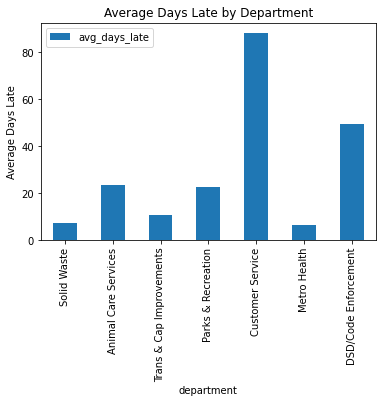

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

dept_late.set_index('department').plot.bar()
plt.title('Average Days Late by Department')
plt.ylabel('Average Days Late')

Looks to be a significant difference between departments

12. How do number of days late depend on department and request type?

In [110]:
(df
 .filter(df.case_late == True)
 .groupby('department', 'service_request_type')
 .agg(avg('num_days_late').alias('avg_days_late'), 
      max('num_days_late').alias('max_days_late'))
 .sort(col('avg_days_late').desc())
).show(30, truncate = False)

+------------------------+----------------------------------------+------------------+------------------+
|department              |service_request_type                    |avg_days_late     |max_days_late     |
+------------------------+----------------------------------------+------------------+------------------+
|DSD/Code Enforcement    |Zoning: Recycle Yard                    |210.89201994318182|494.94844910000006|
|DSD/Code Enforcement    |Zoning: Junk Yards                      |200.20517608494276|494.949838        |
|DSD/Code Enforcement    |Structure/Housing Maintenance           |190.20707698509807|345.30469910000005|
|DSD/Code Enforcement    |Donation Container Enforcement          |171.09115313942615|391.2158102       |
|DSD/Code Enforcement    |Storage of Used Mattress                |163.96812829714287|288.504456        |
|DSD/Code Enforcement    |Labeling for Used Mattress              |162.43032902285717|288.5038773       |
|DSD/Code Enforcement    |Record Keeping of Us

There is huge variability in average number of days late based on the department and request type. DSD/Code Enforcement looks to be very late on their jobs in general. 

In [120]:
df.sort(asc('case_opened_date')).show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1013225542           
 case_opened_date     | 2017-01-01 03:22:00  
 case_closed_date     | 2017-01-04 16:10:00  
 case_due_date        | 2017-01-05 08:30:00  
 case_late            | false                
 num_days_late        | -0.680462963         
 case_closed          | true                 
 service_request_type | No Pickup            
 SLA_days             | 4.213252315          
 case_status          | Closed               
 request_address      | 10010  GENTLE POI... 
 council_district     | 7                    
 case_age             | 1965                 
 days_to_closed       | 3                    
 case_lifetime        | 3                    
 department           | Solid Waste          
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row

